In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant
import re
import gzip
import json
from sklearn.model_selection import train_test_split

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
english_stops = set(stopwords.words('english'))
lemma = nltk.wordnet.WordNetLemmatizer()
sno = nltk.stem.SnowballStemmer('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Va8qhRHr_MCST7_dNxNtI4mtcoFyGYLI' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Va8qhRHr_MCST7_dNxNtI4mtcoFyGYLI" -O Toys_and_Games_5.json.gz && rm -rf /tmp/cookies.txt

--2023-06-06 13:53:03--  https://docs.google.com/uc?export=download&confirm=t&id=1Va8qhRHr_MCST7_dNxNtI4mtcoFyGYLI
Resolving docs.google.com (docs.google.com)... 173.194.79.100, 173.194.79.138, 173.194.79.139, ...
Connecting to docs.google.com (docs.google.com)|173.194.79.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-8g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ktngqbsjb57ggvpn3qv1fht2vod99eqb/1686059550000/04268100670184909597/*/1Va8qhRHr_MCST7_dNxNtI4mtcoFyGYLI?e=download&uuid=83da0512-3955-4c43-8dce-035f1039c61c [following]
--2023-06-06 13:53:03--  https://doc-04-8g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ktngqbsjb57ggvpn3qv1fht2vod99eqb/1686059550000/04268100670184909597/*/1Va8qhRHr_MCST7_dNxNtI4mtcoFyGYLI?e=download&uuid=83da0512-3955-4c43-8dce-035f1039c61c
Resolving doc-04-8g-docs.googleusercontent.com (doc-04-8g-docs.googleusercontent.com)... 142.251.18.132, 

In [3]:
def read_data(n=1000):
    fin = gzip.open('Toys_and_Games_5.json.gz', 'rt', encoding='UTF-8')

    data = {'review':[], 'overall':[]}
    for i in range(n):
        try:
            d = json.loads(fin.readline())
            data['review'].append(d['reviewText'])
            data['overall'].append(int(d['overall']))
        except:
            pass
            
    df = pd.DataFrame(data)

    del data
    del fin
    del d

    x_data = df['review']
    y_data = df['overall']

    x_data = x_data.replace({'<.*?>': ''}, regex=True)
    x_data = x_data.replace({'[^0-9A-Za-z #+_]': ' '}, regex=True)
    x_data = x_data.apply(lambda review: [w for w in review.split() if w not in english_stops])
    x_data = x_data.apply(lambda review: [w.lower() for w in review])
    # x_data = x_data.apply(lambda review: [lemma.lemmatize(w) for w in review])
    x_data = x_data.apply(lambda review: [sno.stem(w) for w in review])


    return x_data, y_data

In [4]:
def get_max_length(x_train):
    review_length = []
    for review in x_train:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

def one_hot(y):
    ret = np.zeros((y.size, y.max()))

    ret[np.arange(y.size), y-1] = 1.0
    return ret

In [5]:
X, Y = read_data(2000000)

In [6]:
def get_135(x, y):
    x_135 = []
    y_135 = []

    x_24 = []
    y_24 = []
    x_ = x.values.tolist()

    for index, value in enumerate(Y.values.tolist()):
        if value==2 or value==4:
            x_24.append(x_[index])
            y_24.append(value)
        else:
            x_135.append(x_[index])
            y_135.append(value)
    del x_
    return x_135, x_24, y_135, y_24

In [7]:
def get_data(x, y, mode='default'):
    if mode=='default':
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.05, shuffle=True)
        y_train = one_hot(y_train.values)
    else:
        x_train, x_test, y_train, y_test = get_135(x, y)
        y_train = one_hot(np.array(y_train))

    return x_train, x_test, y_train, y_test

In [8]:
x_train, x_test, y_train, y_test = get_data(X, Y, '135')

In [9]:
tok = Tokenizer()
tok.fit_on_texts(x_train)
vocab_size = len(tok.word_index)+1
encd_rev = tok.texts_to_sequences(x_train)
encd_rev_test = tok.texts_to_sequences(x_test)
max_len = get_max_length(x_train)
embed_dim=200

In [10]:
x_train_ = pad_sequences(encd_rev, maxlen=max_len, padding='post', truncating='post')
x_test_ = pad_sequences(encd_rev_test, maxlen=max_len, padding='post', truncating='post')

In [11]:
model = Sequential()
model.add(Embedding(vocab_size, 200, input_length=max_len))
# model.add(tf.keras.layers.GRU(128, dropout=0.2))
# model.add(Dropout(0.1))
# model.add(tf.keras.layers.LSTM(128))
# model.add(LSTM(LSTM_OUT))
# model.add(Dropout(0.2))

model.add(tf.keras.layers.Bidirectional(LSTM(128, dropout=0.2)))
# model.add(tf.keras.layers.Dense(128, activation='relu'))
# model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
x_train_.shape

(1497438, 22)

In [13]:
h = model.fit(x_train_, y_train, batch_size=256, epochs=5, validation_split=0.1)


Epoch 1/5
5265/5265 [==============================] - 108s 19ms/step - loss: 0.2677 - accuracy: 0.9036 - val_loss: 0.2241 - val_accuracy: 0.9193
Epoch 2/5
5265/5265 [==============================] - 62s 12ms/step - loss: 0.2369 - accuracy: 0.9144 - val_loss: 0.2175 - val_accuracy: 0.9207
Epoch 3/5
5265/5265 [==============================] - 61s 12ms/step - loss: 0.2257 - accuracy: 0.9186 - val_loss: 0.2097 - val_accuracy: 0.9249
Epoch 4/5
5265/5265 [==============================] - 61s 11ms/step - loss: 0.2179 - accuracy: 0.9215 - val_loss: 0.2064 - val_accuracy: 0.9259
Epoch 5/5
5265/5265 [==============================] - 61s 12ms/step - loss: 0.2114 - accuracy: 0.9240 - val_loss: 0.2051 - val_accuracy: 0.9273


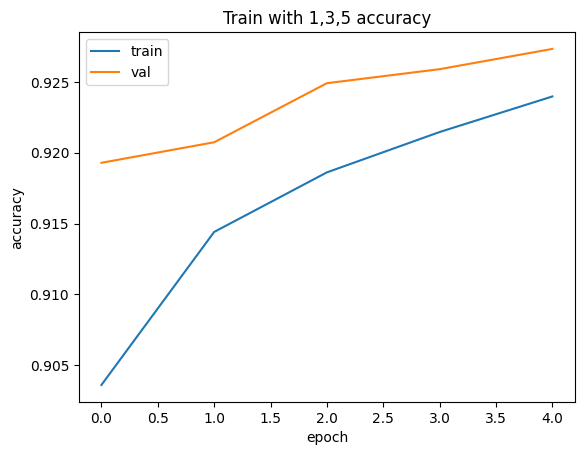

In [14]:
from matplotlib import pyplot as plt
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Train with 1,3,5 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
y_pred = model.predict(x_test_, batch_size=256)

1291/1291 [==============================] - 5s 3ms/step


In [30]:
def print_135(x):
    for data in x:
        print(x_train[data])
        print(f'True label: {y_test[data]}, Predicted label: {np.argmax(y_pred[data])+1}')

In [31]:
print_135([0, 1, 4, 5, 15, 7460, 7476, 7491])

['the', 'stain', 'glass', 'page', 'pretti', 'cool', 'and', 'nice', 'black', 'outlin', 'super', 'dark', 'thick', 'and', 'dragon', 'fight', 'wizard']
True label: 4, Predicted label: 5
['my', '11', 'love', 'i', 'know', 'i', 'realli', 'bought', 'i', 'want', 'see', 'pictur', 'i', 'lucki', 'enough', 'someon', 'i', 'could', 'justifi', 'buy', 'present', 'dragon', 'wizard', 'say', 'with', 'wonder', 'see', 'vellum', 'like', 'page', 'make', 'stain', 'glass', 'color', 'marker', 'anyth', 'els', 'realli', 'color', 'pencil', 'watercolor', 'mayb', 'light', 'shine', 'page', 'make', 'look', 'lumin', 'gorgeous', 'even', 'perfectionist', 'get', 'intimid', 'art', 'draw', 'tend', 'find', 'stain', 'glass', 'book', 'easi', 'get', 'result', 'happi', 'tend', 'enjoy', 'confid', 'build', 'experi']
True label: 2, Predicted label: 3
['i', 'love']
True label: 2, Predicted label: 3
['my', 'husband', 'love', 'it', 'he', 'is', 'in', 'to', 'dragon']
True label: 4, Predicted label: 3
['this', 'tini', 'book', 'onli', 'pag

In [18]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1LXAJ-5z7qKjQzCsKi93xwF3oXqP-ZoPi' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1LXAJ-5z7qKjQzCsKi93xwF3oXqP-ZoPi" -O imdb.csv && rm -rf /tmp/cookies.txt

--2023-06-06 14:10:04--  https://docs.google.com/uc?export=download&confirm=&id=1LXAJ-5z7qKjQzCsKi93xwF3oXqP-ZoPi
Resolving docs.google.com (docs.google.com)... 108.177.119.139, 108.177.119.113, 108.177.119.101, ...
Connecting to docs.google.com (docs.google.com)|108.177.119.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-2c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9ioka2v6qbo1of2bmgn4r7hu1kqr6ao8/1686060600000/10793604139831864846/*/1LXAJ-5z7qKjQzCsKi93xwF3oXqP-ZoPi?e=download&uuid=119b527b-bb5c-424a-9895-6434356ba9eb [following]
--2023-06-06 14:10:12--  https://doc-0o-2c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9ioka2v6qbo1of2bmgn4r7hu1kqr6ao8/1686060600000/10793604139831864846/*/1LXAJ-5z7qKjQzCsKi93xwF3oXqP-ZoPi?e=download&uuid=119b527b-bb5c-424a-9895-6434356ba9eb
Resolving doc-0o-2c-docs.googleusercontent.com (doc-0o-2c-docs.googleusercontent.com)... 142.251.31.13

In [19]:
def load_dataset():
    df = pd.read_csv('imdb.csv')
    x_data = df['review']
    y_data = df['sentiment']

    x_data = x_data.replace({'<.*?>': ''}, regex=True)  # remove html tag
    x_data = x_data.replace({'[^A-Za-z]': ' '}, regex=True)  # remove non alphabet
    x_data = x_data.apply(lambda review: [w for w in review.split() if w not in english_stops])  # remove stop words
    x_data = x_data.apply(lambda review: [w.lower() for w in review])  # lower case

    y_data = y_data.replace('positive', 1)
    y_data = y_data.replace('negative', 0)

    return x_data, y_data
    

In [20]:
x_data, y_data = load_dataset()


In [21]:
imdb_data_X = tok.texts_to_sequences(x_data)

In [22]:
imdb_data_X = pad_sequences(imdb_data_X, maxlen=max_len, padding='post', truncating='post')

In [23]:
y_pred_imdb = model.predict(imdb_data_X, batch_size=256)

196/196 [==============================] - 1s 7ms/step


In [24]:
y_data

0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64

In [28]:
def print_imdb(x):
    for data in x:
        print(x_data[data])
        print(f'Imdb label: {y_data.values[data]}, Predicted label: {np.argmax(y_pred_imdb[data])+1}')

In [29]:
print_imdb([0, 49996, 49988, 49966, 49990])

['one', 'reviewers', 'mentioned', 'watching', 'oz', 'episode', 'hooked', 'they', 'right', 'exactly', 'happened', 'the', 'first', 'thing', 'struck', 'oz', 'brutality', 'unflinching', 'scenes', 'violence', 'set', 'right', 'word', 'go', 'trust', 'show', 'faint', 'hearted', 'timid', 'this', 'show', 'pulls', 'punches', 'regards', 'drugs', 'sex', 'violence', 'its', 'hardcore', 'classic', 'use', 'word', 'it', 'called', 'oz', 'nickname', 'given', 'oswald', 'maximum', 'security', 'state', 'penitentary', 'it', 'focuses', 'mainly', 'emerald', 'city', 'experimental', 'section', 'prison', 'cells', 'glass', 'fronts', 'face', 'inwards', 'privacy', 'high', 'agenda', 'em', 'city', 'home', 'many', 'aryans', 'muslims', 'gangstas', 'latinos', 'christians', 'italians', 'irish', 'scuffles', 'death', 'stares', 'dodgy', 'dealings', 'shady', 'agreements', 'never', 'far', 'away', 'i', 'would', 'say', 'main', 'appeal', 'show', 'due', 'fact', 'goes', 'shows', 'dare', 'forget', 'pretty', 'pictures', 'painted', 'ma

In [27]:
del model